In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from sklearn.metrics import jaccard_score, f1_score

In [17]:

def build_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(1, (1, 1), activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Load MRI scan and corresponding mask
def load_dataset(folder_path, tumor_type="Giloma", img_size=(128, 128)):
    images, masks = [], []
    tumor_path = os.path.join(folder_path, tumor_type)
    for file in os.listdir(tumor_path):
        if "_mask" not in file:  # Only load original MRI scans
            img_path = os.path.join(tumor_path, file)
            mask_path = os.path.join(tumor_path, file.replace(".png", "_mask.png"))
            
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            image = cv2.resize(image, img_size) / 255.0
            mask = cv2.resize(mask, img_size) / 255.0
            
            images.append(image)
            masks.append(mask)
    
    images = np.expand_dims(np.array(images), axis=-1)
    masks = np.expand_dims(np.array(masks), axis=-1)
    return images, masks

In [19]:

try:
    model = load_model('brain_tumor_segmentation_model.h5')
except:
    model = build_model()

In [20]:

data_folder = "data/data"
images, masks = load_dataset(data_folder, tumor_type="Glioma")


model.fit(images, masks, epochs=10, batch_size=4, validation_split=0.2)
model.save('brain_tumor_segmentation_model.h5')


Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 64), dtype=float32, path=sequential_1/conv2d_6/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:

def segment_tumor(image):
    image_input = np.expand_dims(image, axis=(0, -1))  # Reshape for model
    prediction = model.predict(image_input)
    predicted_mask = (prediction > 0.5).astype(np.uint8)
    return predicted_mask.squeeze()


def evaluate_segmentation(true_mask, predicted_mask):
    dice_score = f1_score(true_mask.flatten(), predicted_mask.flatten())
    jaccard_idx = jaccard_score(true_mask.flatten(), predicted_mask.flatten())
    return dice_score, jaccard_idx

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


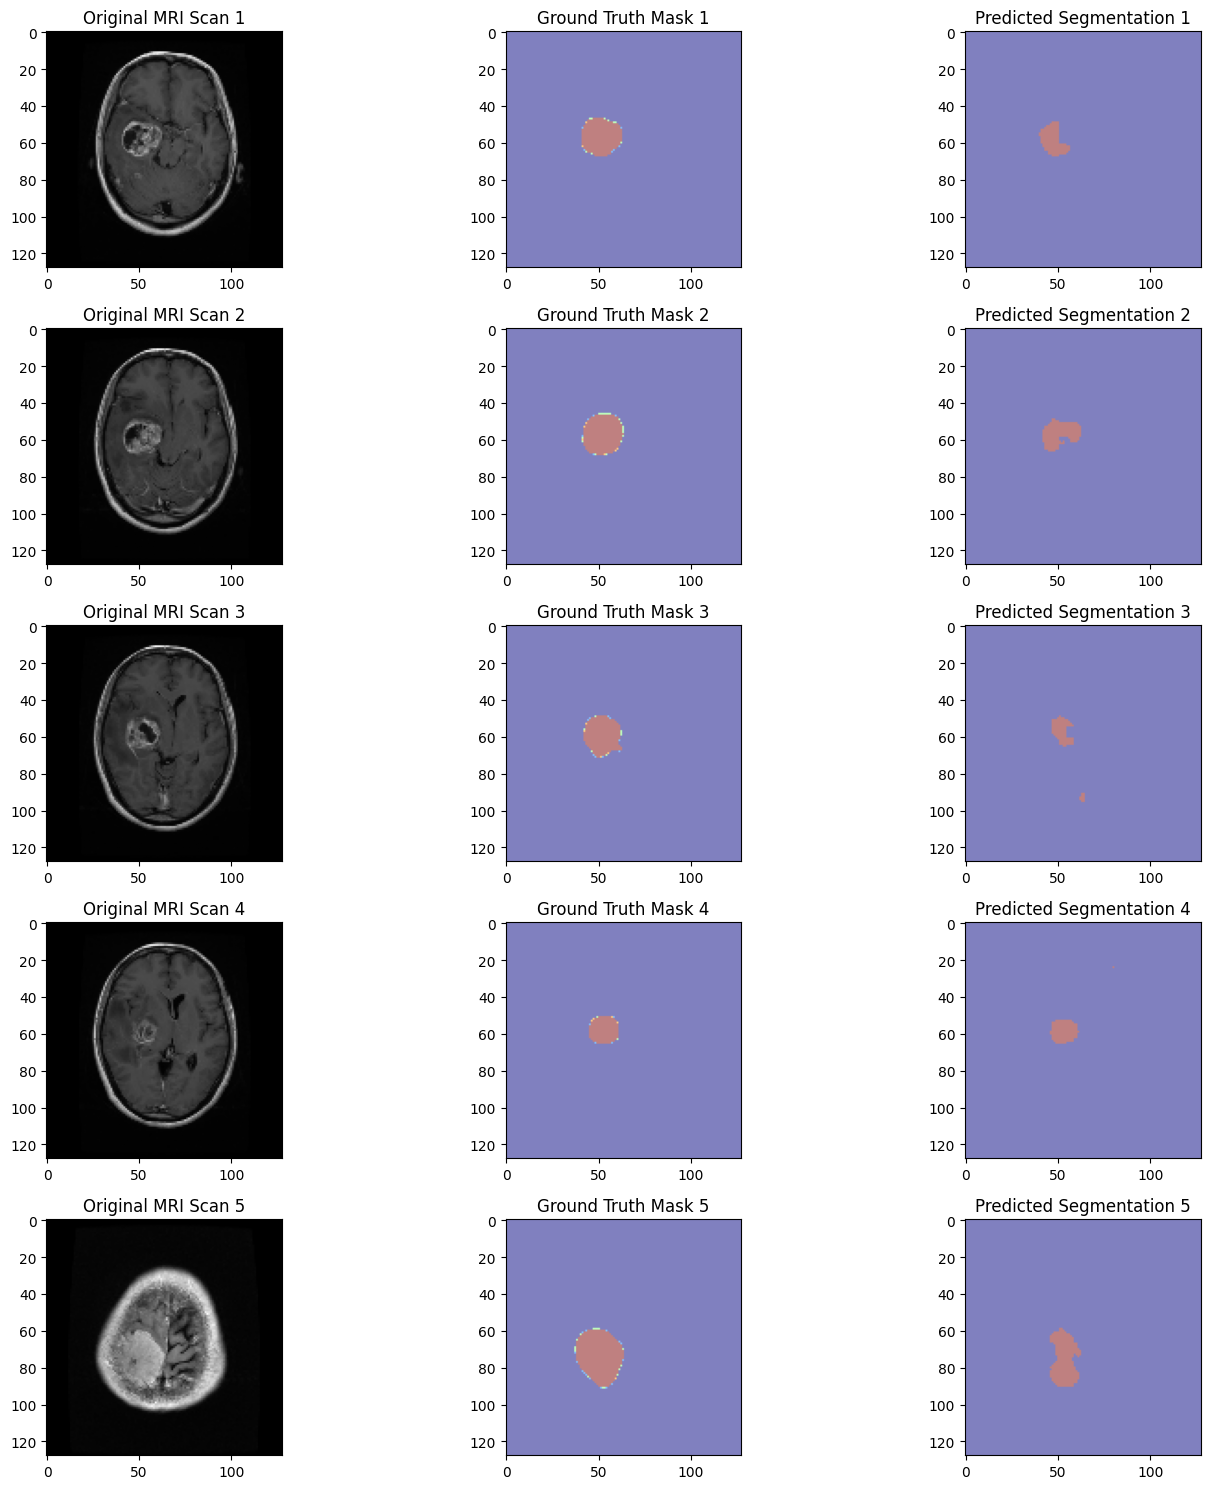

In [22]:
# Sample execution
sample_idx = 0
mri_scan = images[sample_idx].squeeze()
true_mask = masks[sample_idx].squeeze()
predicted_mask = segment_tumor(mri_scan)

# Display multiple examples
num_examples = 5
plt.figure(figsize=(15, num_examples * 3))
for i in range(num_examples):
    mri_scan = images[i].squeeze()
    true_mask = masks[i].squeeze()
    predicted_mask = segment_tumor(mri_scan)
    
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(mri_scan, cmap='gray')
    plt.title(f"Original MRI Scan {i+1}")
    
    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(true_mask, cmap='jet', alpha=0.5)
    plt.title(f"Ground Truth Mask {i+1}")
    
    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)
    plt.title(f"Predicted Segmentation {i+1}")

plt.tight_layout()
plt.show()
